In [1]:
import h5py
import numpy as np

# Path to your .mat file
mat_file_path = r'E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'

# Use h5py to load the .mat file
with h5py.File(mat_file_path, 'r') as f:
    ae_all = f['AE_ALL']

    # Access the first element (which is a reference) for each condition
    bf_ref = ae_all['BF'][0]  # BF first channel references
    gf_ref = ae_all['GF'][0]  # GF first channel references
    tf_ref = ae_all['TF'][0]  # TF first channel references
    n_ref = ae_all['N'][0]    # N first channel references
    bfi_ref = ae_all['BFI'][0]    # BFI first channel references
    gfi_ref = ae_all['GFI'][0]    # GFI first channel references
    ni_ref = ae_all['NI'][0]    # NI first channel references

    # Dereference the first HDF5 object reference to access actual data
    bf_data = np.array(f[bf_ref[0]])  # Access data via dereferencing
    gf_data = np.array(f[gf_ref[0]])  # Access data for GF
    tf_data = np.array(f[tf_ref[0]])  # Access data for TF
    n_data = np.array(f[n_ref[0]])    # Access data for N
    bfi_data = np.array(f[bfi_ref[0]])  # Access data for BFI
    gfi_data = np.array(f[gfi_ref[0]])  # Access data for GFI
    ni_data = np.array(f[ni_ref[0]])  # Access data for NI

    # Transpose the data to (40, 1,000,000) for each fault condition
    bf_data = bf_data.T
    gf_data = gf_data.T
    tf_data = tf_data.T
    n_data = n_data.T
    bfi_data = bfi_data.T
    gfi_data = gfi_data.T
    ni_data = ni_data.T

    # Check the shapes of the data after transposing
    print("BF shape:", bf_data.shape)
    print("GF shape:", gf_data.shape)
    print("TF shape:", tf_data.shape)
    print("N shape:", n_data.shape)
    print("BFI shape:", bfi_data.shape)
    print("GFI shape:", gfi_data.shape)
    print("NI shape:", ni_data.shape)


BF shape: (40, 1000000)
GF shape: (40, 1000000)
TF shape: (40, 1000000)
N shape: (40, 1000000)
BFI shape: (40, 1000000)
GFI shape: (40, 1000000)
NI shape: (40, 1000000)


In [2]:
import pywt
import numpy as np

# Improved Wavelet Threshold Denoising (IWTD) with adaptive thresholding
def improved_wavelet_denoise(signal_segment, wavelet='db4', level=5, alpha=0.5, beta=0.75):
    coeffs = pywt.wavedec(signal_segment, wavelet, level=level)

    # Adaptive thresholding for each detail level
    denoised_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for i in range(1, len(coeffs)):
        detail_coeff = coeffs[i]
        # Adaptive threshold: calculate based on standard deviation
        threshold = alpha * np.sqrt(2 * np.log(len(detail_coeff))) * np.std(detail_coeff)
        # Mixed soft-hard thresholding
        denoised_coeff = np.where(np.abs(detail_coeff) > threshold, 
                                  np.sign(detail_coeff) * np.maximum(np.abs(detail_coeff) - beta * threshold, 0), 0)
        denoised_coeffs.append(denoised_coeff)

    return pywt.waverec(denoised_coeffs, wavelet)

# Function to apply IWTD to all data segments
def apply_denoising(data, segment_size=10000):
    denoised_data = []
    for signal in data:
        denoised_signal = []
        for i in range(0, len(signal), segment_size):
            segment = signal[i:i + segment_size]
            denoised_segment = improved_wavelet_denoise(segment)
            denoised_signal.extend(denoised_segment)
        denoised_data.append(denoised_signal)
    return np.array(denoised_data)

# Apply IWTD to each condition
bf_denoised = apply_denoising(bf_data)
gf_denoised = apply_denoising(gf_data)
tf_denoised = apply_denoising(tf_data)
n_denoised = apply_denoising(n_data)
bfi_denoised = apply_denoising(bfi_data)
gfi_denoised = apply_denoising(gfi_data)
ni_denoised = apply_denoising(ni_data)

# Check the shape of the denoised data
print("BF denoised shape:", bf_denoised.shape)
print("GF denoised shape:", gf_denoised.shape)
print("TF denoised shape:", tf_denoised.shape)
print("N denoised shape:", n_denoised.shape)
print("BFI denoised shape:", bfi_denoised.shape)
print("GFI denoised shape:", gfi_denoised.shape)
print("NI denoised shape:", ni_denoised.shape)


BF denoised shape: (40, 1000000)
GF denoised shape: (40, 1000000)
TF denoised shape: (40, 1000000)
N denoised shape: (40, 1000000)
BFI denoised shape: (40, 1000000)
GFI denoised shape: (40, 1000000)
NI denoised shape: (40, 1000000)


In [3]:
import numpy as np
import pandas as pd

# Function to extract enhanced time-domain features from a signal
def extract_time_domain_features(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    rms = np.sqrt(np.mean(signal**2))
    peak = np.max(np.abs(signal))
    mean_abs = np.mean(np.abs(signal))

    features = {
        'mean': mean,
        'std_dev': std_dev,
        'rms': rms,
        'variance': np.var(signal),
        'kurtosis': pd.Series(signal).kurtosis(),
        'skewness': pd.Series(signal).skew(),
        'peak_to_peak': np.ptp(signal),
        'energy': np.sum(signal**2),
        'crest_factor': peak / rms,  # Crest Factor = Peak / RMS
        'impulse_factor': peak / mean_abs,  # Impulse Factor = Peak / Mean Abs
        'shape_factor': rms / mean_abs,  # Shape Factor = RMS / Mean Abs
        'clearance_factor': peak / np.square(rms),  # Clearance Factor = Peak / RMS^2
        'margin_factor': peak / (np.mean(np.abs(signal)**3)**(1/3))  # Margin Factor = Peak / (Mean Abs^3)^(1/3)
    }
    return features

# Apply feature extraction to all samples for each condition
def extract_features_from_condition(data):
    feature_list = []
    for signal in data:
        features = extract_time_domain_features(signal)
        feature_list.append(features)
    return pd.DataFrame(feature_list)

# Extract time-domain features for each condition
bf_time_features = extract_features_from_condition(bf_denoised)
gf_time_features = extract_features_from_condition(gf_denoised)
tf_time_features = extract_features_from_condition(tf_denoised)
n_time_features = extract_features_from_condition(n_denoised)
bfi_time_features = extract_features_from_condition(bfi_denoised)
gfi_time_features = extract_features_from_condition(gfi_denoised)
ni_time_features = extract_features_from_condition(ni_denoised)

# Check the first few rows of extracted features for BF
print(bf_time_features.head())


       mean   std_dev       rms  variance   kurtosis  skewness  peak_to_peak  \
0  0.001298  0.067306  0.067319  0.004530  11.888021 -0.129334      1.587605   
1  0.001375  0.067832  0.067846  0.004601  12.891743 -0.092623      2.149355   
2  0.001623  0.067455  0.067474  0.004550  10.566970 -0.093656      1.562316   
3  0.001621  0.063890  0.063911  0.004082  14.500423 -0.183383      1.741506   
4  0.002076  0.065358  0.065391  0.004272  11.692296 -0.182324      1.614496   

        energy  crest_factor  impulse_factor  shape_factor  clearance_factor  \
0  4531.782149     12.239924       20.367874      1.664052        181.821072   
1  4603.059541     17.514736       29.169620      1.665433        258.154855   
2  4552.782012     11.866397       19.647117      1.655694        175.865424   
3  4084.586976     13.953311       23.888972      1.712065        218.324868   
4  4276.001635     12.817321       21.349176      1.665650        196.010039   

   margin_factor  
0       8.312919  


In [4]:
import numpy as np
import pandas as pd

# Function to extract frequency-domain features using FFT
def extract_frequency_domain_features(signal, sampling_rate=1000000):
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    fft_vals = np.fft.fft(signal)
    fft_power = np.abs(fft_vals)**2
    
    # Normalize the power spectrum
    fft_power_normalized = fft_power / np.sum(fft_power)

    # Spectral roll-off (85%)
    spectral_roll_off = np.sum(np.cumsum(fft_power_normalized) <= 0.85)

    features = {
        'dominant_freq': freqs[np.argmax(fft_power)],
        'power_spectral_density': np.mean(fft_power),
        'spectral_centroid': np.sum(freqs * fft_power) / np.sum(fft_power),
        'spectral_bandwidth': np.sqrt(np.sum((freqs - np.mean(freqs))**2 * fft_power) / np.sum(fft_power)),
        'spectral_flatness': np.exp(np.mean(np.log(fft_power + 1e-12))) / np.mean(fft_power + 1e-12),  # Spectral Flatness
        'spectral_roll_off': freqs[spectral_roll_off],  # Spectral Roll-off (85% point)
        'spectral_entropy': -np.sum(fft_power_normalized * np.log(fft_power_normalized + 1e-12)),  # Spectral Entropy
        'harmonic_energy': np.sum(np.abs(fft_vals[::2])**2)  # Harmonic Energy (sum of even harmonics)
    }
    return features

# Apply FFT feature extraction to all samples for each condition
def extract_fft_features_from_condition(data):
    feature_list = []
    for signal in data:
        features = extract_frequency_domain_features(signal)
        feature_list.append(features)
    return pd.DataFrame(feature_list)

# Extract frequency-domain features for each condition
bf_fft_features = extract_fft_features_from_condition(bf_denoised)
gf_fft_features = extract_fft_features_from_condition(gf_denoised)
tf_fft_features = extract_fft_features_from_condition(tf_denoised)
n_fft_features = extract_fft_features_from_condition(n_denoised)
bfi_fft_features = extract_fft_features_from_condition(bfi_denoised)
gfi_fft_features = extract_fft_features_from_condition(gfi_denoised)
ni_fft_features = extract_fft_features_from_condition(ni_denoised)

# Check the first few rows of FFT features for BF
print(bf_fft_features.head())


   dominant_freq  power_spectral_density  spectral_centroid  \
0         5331.0             4531.782149          -0.000996   
1         5340.0             4603.059541          -0.000835   
2         5332.0             4552.782012          -0.001478   
3         5326.0             4084.586976          -0.000058   
4            0.0             4276.001635          -0.002425   

   spectral_bandwidth  spectral_flatness  spectral_roll_off  spectral_entropy  \
0        24040.029006           0.003753           -10657.0         10.307673   
1        24147.400891           0.003870           -10647.0         10.325579   
2        24245.256867           0.003953           -10642.0         10.315186   
3        24002.107529           0.003365           -10845.0         10.282677   
4        24231.459664           0.003631           -10712.0         10.321912   

   harmonic_energy  
0     2.242113e+09  
1     2.317143e+09  
2     2.307670e+09  
3     2.039927e+09  
4     2.162606e+09  


In [5]:
import pywt
import numpy as np
import pandas as pd

# Function to extract CWT features (wavelet energy, entropy, and time-frequency features)
def extract_cwt_features(signal, wavelet='morl'):
    widths = np.arange(1, 31)
    cwt_matrix, freqs = pywt.cwt(signal, widths, wavelet)
    
    # Calculate wavelet energy and entropy
    wavelet_energy = np.sum(cwt_matrix**2)
    wavelet_entropy = -np.sum(cwt_matrix**2 * np.log(cwt_matrix**2 + 1e-12))
    
    # Additional time-frequency features
    max_freq_index = np.argmax(np.sum(cwt_matrix**2, axis=1))  # Index of max frequency component
    max_freq = freqs[max_freq_index]
    
    mean_freq = np.sum(freqs * np.sum(cwt_matrix**2, axis=1)) / np.sum(cwt_matrix**2)
    std_freq = np.sqrt(np.sum((freqs - mean_freq)**2 * np.sum(cwt_matrix**2, axis=1)) / np.sum(cwt_matrix**2))
    
    # Variance, skewness, and kurtosis of the wavelet coefficients
    wavelet_coeff_variance = np.var(cwt_matrix)
    wavelet_coeff_kurtosis = pd.Series(cwt_matrix.flatten()).kurtosis()
    wavelet_coeff_skewness = pd.Series(cwt_matrix.flatten()).skew()
    
    features = {
        'wavelet_energy': wavelet_energy,
        'wavelet_entropy': wavelet_entropy,
        'mean_freq': mean_freq,
        'std_freq': std_freq,
        'wavelet_coeff_variance': wavelet_coeff_variance,
        'wavelet_coeff_skewness': wavelet_coeff_skewness,
        'wavelet_coeff_kurtosis': wavelet_coeff_kurtosis
    }
    return features

# Apply CWT feature extraction to all samples for each condition
def extract_cwt_features_from_condition(data):
    feature_list = []
    for signal in data:
        features = extract_cwt_features(signal)
        feature_list.append(features)
    return pd.DataFrame(feature_list)

# Extract CWT-based features for each condition
bf_cwt_features = extract_cwt_features_from_condition(bf_denoised)
gf_cwt_features = extract_cwt_features_from_condition(gf_denoised)
tf_cwt_features = extract_cwt_features_from_condition(tf_denoised)
n_cwt_features = extract_cwt_features_from_condition(n_denoised)
bfi_cwt_features = extract_cwt_features_from_condition(bfi_denoised)
gfi_cwt_features = extract_cwt_features_from_condition(gfi_denoised)
ni_cwt_features = extract_cwt_features_from_condition(ni_denoised)

# Check the first few rows of CWT features for BF
print(bf_cwt_features.head())


   wavelet_energy  wavelet_entropy  mean_freq  std_freq  \
0   199213.433933    275033.964985   0.033470  0.010865   
1   198531.483781    273429.195477   0.033797  0.011115   
2   197100.885806    291444.650969   0.033745  0.011117   
3   197777.835046    238444.021124   0.032915  0.010167   
4   202016.641472    271484.342197   0.033350  0.010606   

   wavelet_coeff_variance  wavelet_coeff_skewness  wavelet_coeff_kurtosis  
0                0.006640               -0.017968              117.738189  
1                0.006618               -0.028010              122.691523  
2                0.006570               -0.015340               96.428696  
3                0.006593                0.001020              144.014339  
4                0.006734               -0.009626              106.007604  


In [6]:
# Function to combine time-domain, frequency-domain, and time-frequency features into one DataFrame
def combine_features(time_df, fft_df, cwt_df):
    combined_df = pd.concat([time_df, fft_df, cwt_df], axis=1)
    return combined_df

# Combine features for each condition
bf_combined = combine_features(bf_time_features, bf_fft_features, bf_cwt_features)
gf_combined = combine_features(gf_time_features, gf_fft_features, gf_cwt_features)
tf_combined = combine_features(tf_time_features, tf_fft_features, tf_cwt_features)
n_combined = combine_features(n_time_features, n_fft_features, n_cwt_features)
bfi_combined = combine_features(bfi_time_features, bfi_fft_features, bfi_cwt_features)
gfi_combined = combine_features(gfi_time_features, gfi_fft_features, gfi_cwt_features)
ni_combined = combine_features(ni_time_features, ni_fft_features, ni_cwt_features)

# Add labels for each condition (BF = 1, GF = 2, TF = 3, N = 0, BFI = 4, GFI = 5, NI = 6)
bf_combined['label'] = 1
gf_combined['label'] = 2
tf_combined['label'] = 3
n_combined['label'] = 0
bfi_combined['label'] = 4
gfi_combined['label'] = 5
ni_combined['label'] = 6

# Combine all conditions into one dataset
combined_all_dataset = pd.concat([bf_combined, gf_combined, tf_combined, n_combined,
                                  bfi_combined, gfi_combined, ni_combined])

# Check the combined dataset structure
print(combined_all_dataset.head())


       mean   std_dev       rms  variance   kurtosis  skewness  peak_to_peak  \
0  0.001298  0.067306  0.067319  0.004530  11.888021 -0.129334      1.587605   
1  0.001375  0.067832  0.067846  0.004601  12.891743 -0.092623      2.149355   
2  0.001623  0.067455  0.067474  0.004550  10.566970 -0.093656      1.562316   
3  0.001621  0.063890  0.063911  0.004082  14.500423 -0.183383      1.741506   
4  0.002076  0.065358  0.065391  0.004272  11.692296 -0.182324      1.614496   

        energy  crest_factor  impulse_factor  ...  spectral_entropy  \
0  4531.782149     12.239924       20.367874  ...         10.307673   
1  4603.059541     17.514736       29.169620  ...         10.325579   
2  4552.782012     11.866397       19.647117  ...         10.315186   
3  4084.586976     13.953311       23.888972  ...         10.282677   
4  4276.001635     12.817321       21.349176  ...         10.321912   

   harmonic_energy  wavelet_energy  wavelet_entropy  mean_freq  std_freq  \
0     2.242113e+

In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = combined_all_dataset.drop(columns=['label']).values
y = combined_all_dataset['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardize the feature set
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Check the shape of the balanced training data
print("Balanced training data shape:", X_train_smote_scaled.shape, "with labels:", y_train_smote.shape)


Balanced training data shape: (259, 28) with labels: (259,)


In [8]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define base classifiers for stacking
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=300)),
    ('svm', SVC(probability=True)),
    ('gb', GradientBoostingClassifier(n_estimators=200))
]

# Define stacking ensemble classifier with RandomForest as the meta-classifier
stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=RandomForestClassifier())

# Train the stacking ensemble model on the balanced data
stacking_clf.fit(X_train_smote_scaled, y_train_smote)

# Make predictions
y_pred = stacking_clf.predict(X_test_scaled)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Ensemble Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Stacking Ensemble Accuracy: 98.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        11
           3       1.00      0.86      0.92         7
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         7

    accuracy                           0.98        56
   macro avg       0.99      0.98      0.98        56
weighted avg       0.98      0.98      0.98        56



In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Define hyperparameter grids for tuning

# Random Forest parameters
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# SVM parameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Set up randomized search for each classifier

# Random Forest
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params,
                               n_iter=10, cv=3, random_state=42, n_jobs=-1)

# SVM
svm_random = RandomizedSearchCV(estimator=SVC(probability=True), param_distributions=svm_params,
                                n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Gradient Boosting
gb_random = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=gb_params,
                               n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Perform the random search on training data
rf_random.fit(X_train_smote_scaled, y_train_smote)
svm_random.fit(X_train_smote_scaled, y_train_smote)
gb_random.fit(X_train_smote_scaled, y_train_smote)

# Get the best estimators from the search
best_rf = rf_random.best_estimator_
best_svm = svm_random.best_estimator_
best_gb = gb_random.best_estimator_

print("Best Random Forest Parameters:", rf_random.best_params_)
print("Best SVM Parameters:", svm_random.best_params_)
print("Best Gradient Boosting Parameters:", gb_random.best_params_)

# Now, set up the stacking classifier with the best models
base_classifiers = [
    ('rf', best_rf),
    ('svm', best_svm),
    ('gb', best_gb)
]

stacking_clf_tuned = StackingClassifier(estimators=base_classifiers, final_estimator=RandomForestClassifier())
stacking_clf_tuned.fit(X_train_smote_scaled, y_train_smote)

# Make predictions
y_pred_tuned = stacking_clf_tuned.predict(X_test_scaled)

# Evaluate the performance
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Stacking Ensemble Accuracy after Tuning: {accuracy_tuned * 100:.2f}%")
print("\nClassification Report after Tuning:")
print(classification_report(y_test, y_pred_tuned))


Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Best SVM Parameters: {'kernel': 'linear', 'gamma': 'auto', 'C': 10}
Best Gradient Boosting Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
Stacking Ensemble Accuracy after Tuning: 100.00%

Classification Report after Tuning:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         7

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1415: RuntimeWarning: Number of classes in training fold (5) does not match total number of classes (6). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1415: RuntimeWarning: Number of classes in training fold (5) does not match total number of classes (6). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\Muham

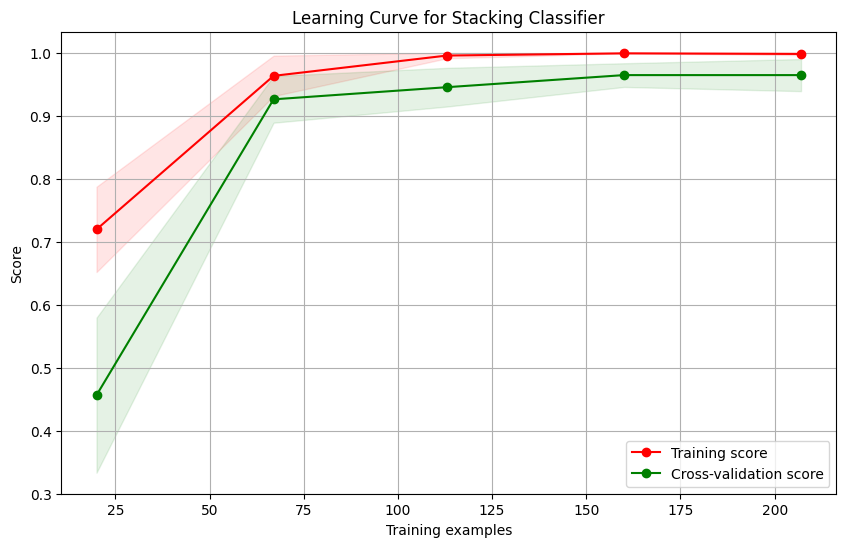

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Get learning curve data
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    # Calculate mean and standard deviation of train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curve for the stacking classifier
plot_learning_curve(stacking_clf, "Learning Curve for Stacking Classifier", X_train_smote_scaled, y_train_smote, cv=5)


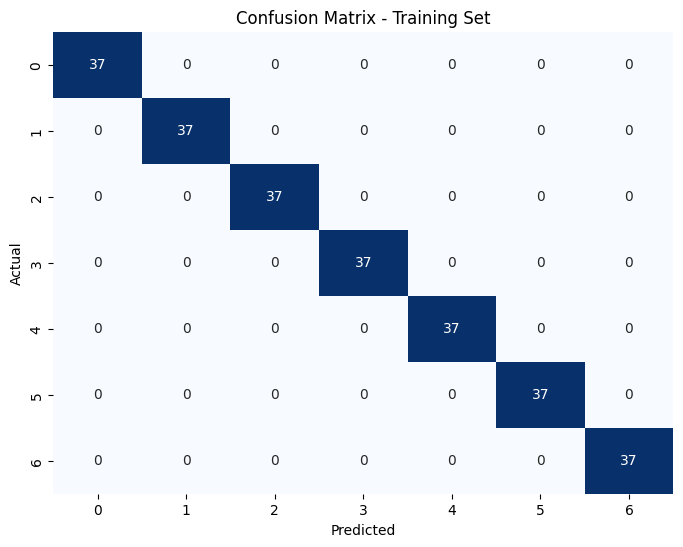

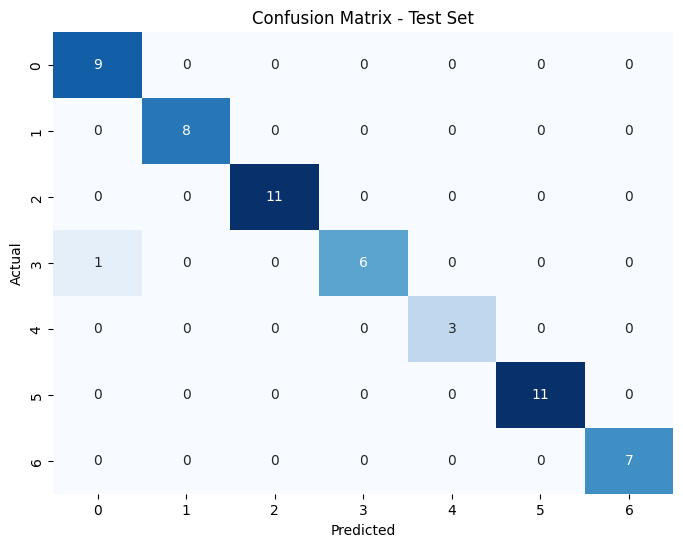

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Predictions for training set
y_train_pred = stacking_clf.predict(X_train_smote_scaled)

# Confusion matrix for training data
plot_confusion_matrix(y_train_smote, y_train_pred, "Confusion Matrix - Training Set")

# Confusion matrix for test data
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix - Test Set")


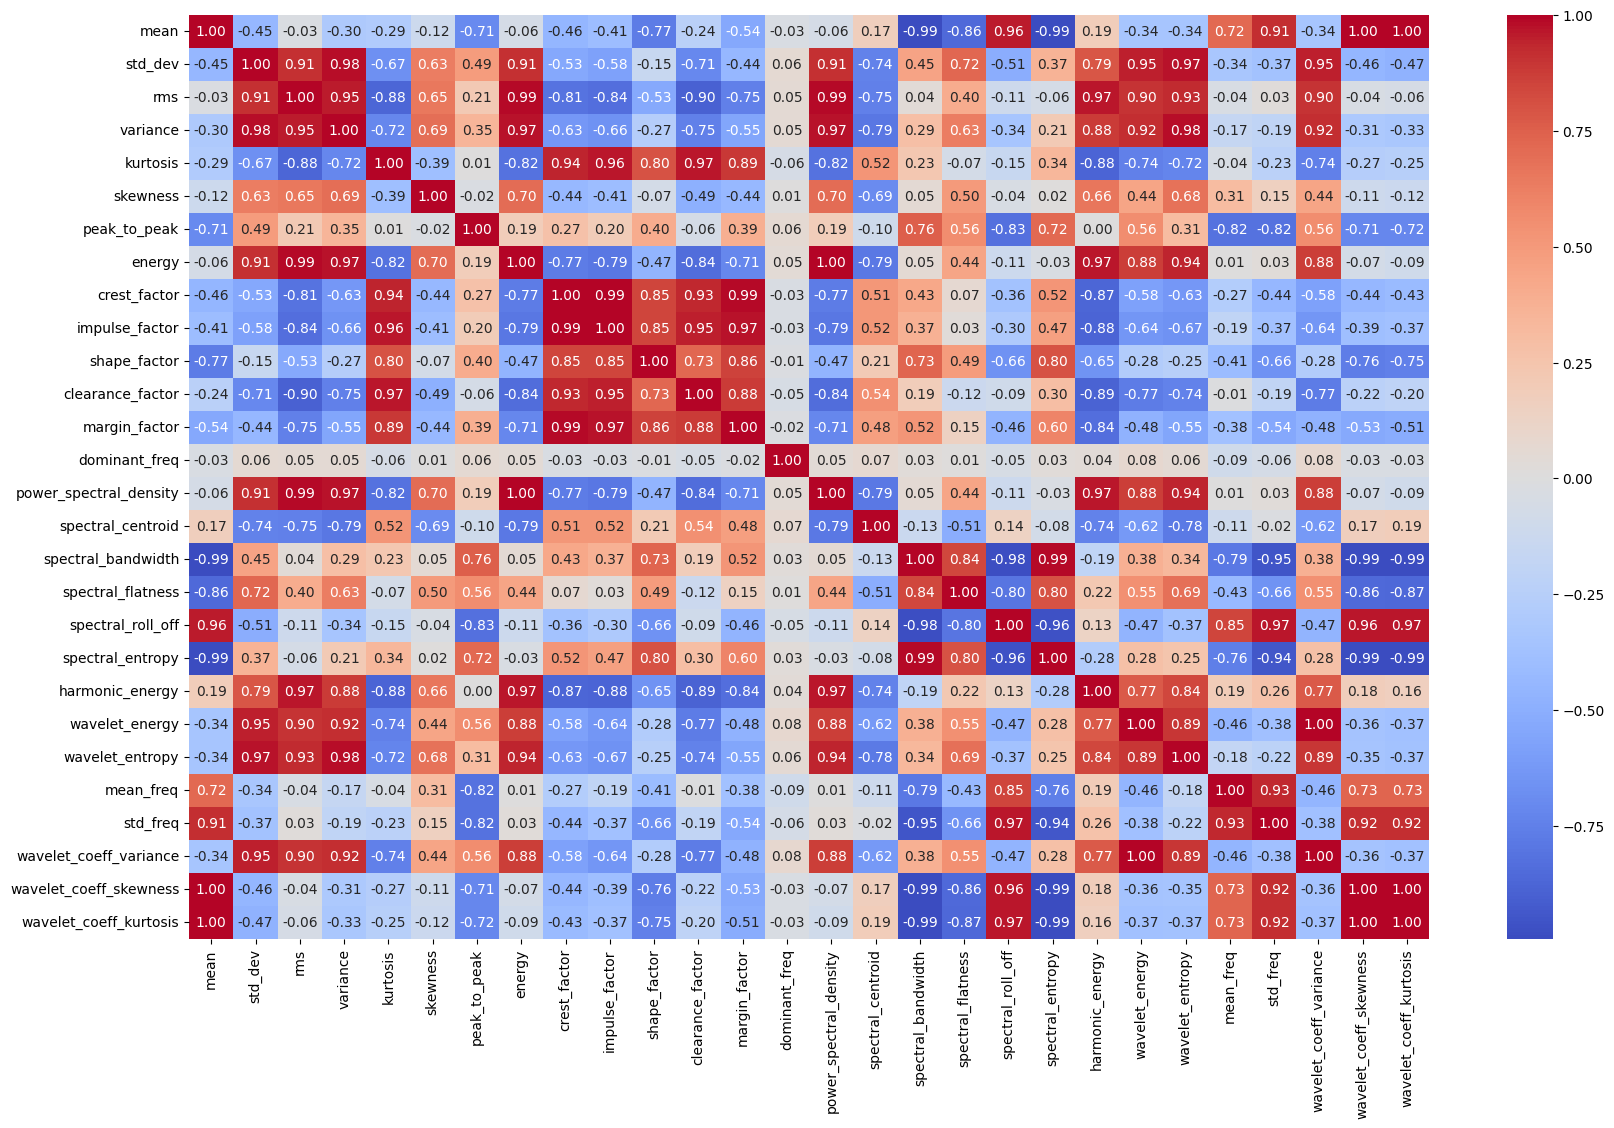

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the entire dataset (excluding the label column)
combined_features = combined_all_dataset.drop(columns=['label'])
correlation_matrix = combined_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
#plt.title('Combined Correlation Heatmap of Time-Domain, Frequency-Domain, and Time-Frequency Features', fontsize=16)
plt.show()


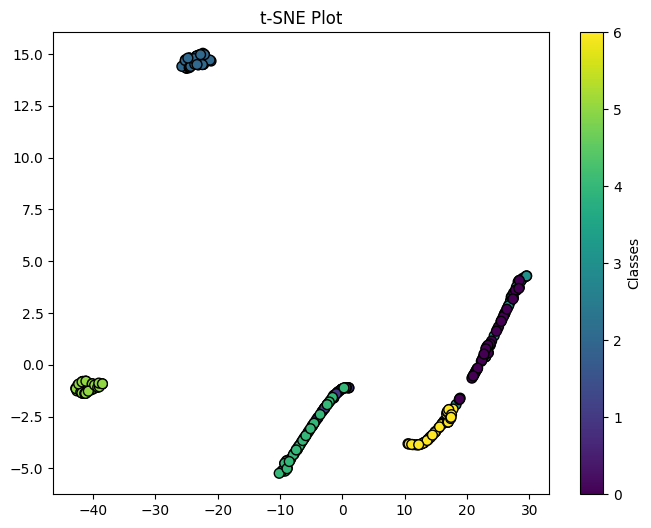

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the features to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(combined_all_dataset)  # or combined_all_dataset.drop(columns=['label'])

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50, edgecolor='k')
plt.title("t-SNE Plot")
plt.colorbar(label='Classes')
plt.show()


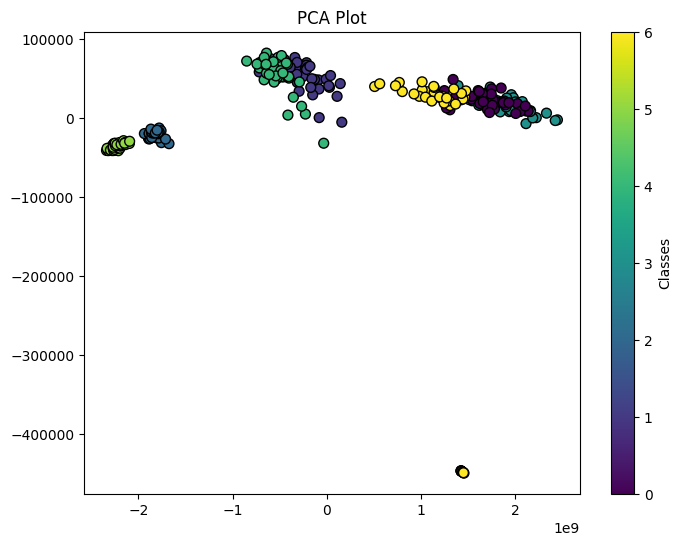

In [27]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the features to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50, edgecolor='k')
plt.title("PCA Plot")
plt.colorbar(label='Classes')
plt.show()


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


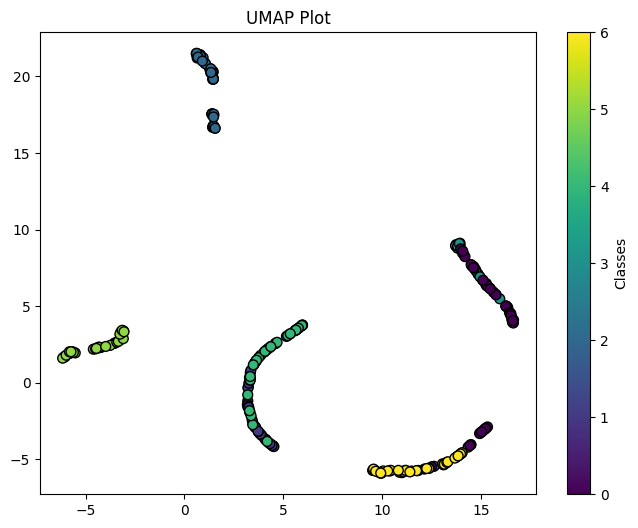

In [28]:
import umap

# Apply UMAP to reduce the features to 2 dimensions
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# Plot the UMAP result
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', s=50, edgecolor='k')
plt.title("UMAP Plot")
plt.colorbar(label='Classes')
plt.show()


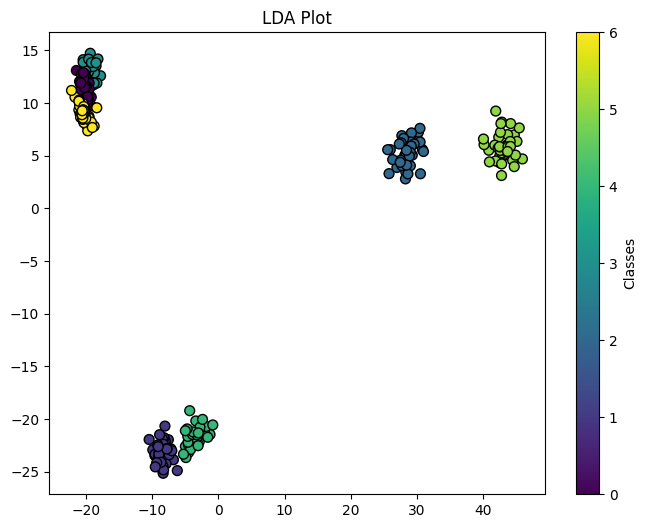

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA to reduce the features to 2 dimensions
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# Plot the LDA result
plt.figure(figsize=(8, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', s=50, edgecolor='k')
plt.title("LDA Plot")
plt.colorbar(label='Classes')
plt.show()
